In [1]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss, matthews_corrcoef, precision_recall_curve, auc
import pickle
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import datetime
from collections import defaultdict, Counter

import sys
sys.path.append('../../')

# utils
from common_utils.logger import init_logger
from common_utils.settings import cfg_init
from common_utils.kf import get_fold
# from common_utils.gbdt.model_gbdt import LightGBM, CatBoost
# from common_utils.gbdt.model_gbdt import LightGBM
from common_utils.feature_engineering.base import run_block, NumericBlock, LabelEncodingBlock, CountEncodingBlock, AggBlock, TargetEncodingBlock
from common_utils.feature_engineering.text import TextLenBlock, TfidfSVDBlock

/home/ryosuke/.cache/pypoetry/virtualenvs/kaggle-pipeline-atmacup-16-kgwzrA72-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from myutils.metrics import mapk

In [3]:
from common_utils.metrics import calc_auc_score

In [4]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'atmacup_16'

    comp_dir_path = '../../'
    comp_folder_name = 'atmaCup16_Dataset'  # compのデータセットのフォルダ名
    comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'

    try:
        exp_name = os.path.basename(__file__).split('.')[0]
    except Exception:
        print('running kernel')
        exp_name = None
    
    exp_name = 'train_gbdt_2stage_training_sep_train_test_exp002' # notebook
    feature_notebook_name = 'train_gbdt_2stage_feature_only_sep_train_test_exp002'

    # ============== model =============
    model_name = 'catboost_gkf'

    # ============== features =============
    catboost_cat_cols = []
    catboost_text_cols = []
    top_k = 40
    # ============== pred target =============
    # target_col = 'target'
    target_col = 'target_multi'

    target_size = 1
    num_class = 5 # multiclassの場合

    # ============== fold =============
    n_fold = 5
    skf_col = 'session_id'
    # group_col = 'session_id'
    group_col = 'session_duplicated_group'
    fold_type = 'gkf'

    objective_cv = 'binary'  # collateとかの型を決める用
    metric_direction = 'maximize'  # gbdtだと使わない
    metrics = 'calc_auc_score'

    # ============== wandb =============
    wandb_note = f'starter'

    # ============== ほぼ固定 =============
    seed = 42

    # ============== set dataset path =============
    if exp_name is not None:
        print('set dataset path')

        outputs_path = comp_dir_path +  \
            f'outputs/{comp_name}/{exp_name}/'

        submission_dir = outputs_path + 'submissions/'
        submission_path = submission_dir + f'submission_{exp_name}.csv'

        model_dir = outputs_path + \
            f'{comp_name}-models/'

        figures_dir = outputs_path + 'figures/'

        log_dir = outputs_path + 'logs/'
        log_path = log_dir + f'{exp_name}.txt'

running kernel
set dataset path


## todo 

last_itemと同じ候補は取り除く

In [5]:
warnings.filterwarnings('ignore')

cfg_init(CFG)

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------
2023年12月17日 14:23:32


In [6]:

import lightgbm as lgb
from catboost import Pool, CatBoostClassifier, CatBoostRegressor
import catboost
import pandas as pd
import matplotlib.pyplot as plt
import pickle


class LightGBM:

    def __init__(self, lgb_params, save_dir=None, imp_dir=None, categorical_feature=None,
                 model_name='lgb',
                 stopping_rounds=50) -> None:
        self.save_dir = save_dir
        self.imp_dir = imp_dir
        self.lgb_params = lgb_params
        self.categorical_feature = categorical_feature

        # saveの切り替え用
        self.model_name = model_name

        self.stopping_rounds = stopping_rounds

    def fit(self, x_train, y_train, train_group, val_group, **fit_params) -> None:

        X_val, y_val = fit_params['eval_set'][0]
        del fit_params['eval_set']

        print('make dataset')
        train_dataset = lgb.Dataset(
            x_train, y_train, group=train_group, categorical_feature=self.categorical_feature)

        val_dataset = lgb.Dataset(
            X_val, y_val, group=val_group, categorical_feature=self.categorical_feature)

        print('start training')
        self.model = lgb.train(params=self.lgb_params,
                               train_set=train_dataset,
                               valid_sets=[train_dataset, val_dataset],
                               callbacks=[lgb.early_stopping(stopping_rounds=self.stopping_rounds,
                                                             verbose=True),
                                          lgb.log_evaluation(50)],
                               **fit_params
                               )

    def plot_importance(self, fold):
        gain_importances = pd.DataFrame({'Feature': self.model.feature_name(),
                                         'Importance': self.model.feature_importance(importance_type='gain')})

        gain_importances.to_csv(
            f'{self.imp_dir}lgb_imp_fold_{fold}_{self.model_name}.csv', index=False)

        gain_importances = gain_importances.nlargest(
            50, 'Importance', keep='first').sort_values(by='Importance', ascending=True)

        gain_importances[['Importance', 'Feature']].plot(
            kind='barh', x='Feature', color='blue', figsize=(12, 8), fontsize=9)
        # plt.ylabel('Feature', fontsize=12)
        plt.title(f'gain importance fold {fold}')
        plt.savefig(
            f'{self.imp_dir}gain_importance_fold{fold}_{self.model_name}.png', bbox_inches='tight')

    def plot_importance_all(self, n_fold=5):
        dfs = [pd.read_csv(
            f'{self.imp_dir}lgb_imp_fold_{fold}_{self.model_name}.csv') for fold in range(n_fold)]
        imp_df = pd.concat(dfs).reset_index(drop=True)
        imp_df = imp_df.groupby(['Feature'])['Importance'].mean().reset_index()

        gain_importances = imp_df.nlargest(
            50, 'Importance', keep='first').sort_values(by='Importance', ascending=True)
        gain_importances[['Importance', 'Feature']].plot(
            kind='barh', x='Feature', color='blue', figsize=(12, 8), fontsize=9)
        plt.title('gain importance all')
        plt.savefig(
            f'{self.imp_dir}gain_importance_all_{self.model_name}.png', bbox_inches='tight')

        return imp_df

    def save(self, fold):
        save_to = f'{self.save_dir}lgb_fold_{fold}_{self.model_name}.txt'
        self.model.save_model(save_to)

    def load(self, fold):
        load_from = f'{self.save_dir}lgb_fold_{fold}_{self.model_name}.txt'
        self.model = lgb.Booster(model_file=load_from)

    def predict(self, x):
        return self.model.predict(x)

    def predict_proba(self, x):
        return self.model.predict_proba(x)


In [7]:
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier, CatBoostRegressor
import catboost
import pandas as pd
import matplotlib.pyplot as plt
import pickle

class CatBoost:

    def __init__(self, lgb_params, mode, save_dir=None, imp_dir=None, categorical_feature=None, text_features=None,
                 model_name='catboost') -> None:
        self.mode = mode
        self.save_dir = save_dir
        self.imp_dir = imp_dir
        self.lgb_params = lgb_params
        self.categorical_feature = categorical_feature
        self.text_features = text_features

        # saveの切り替え用
        self.model_name = model_name

    def fit(self, x_train, y_train, train_group, val_group, **fit_params) -> None:

        print('categorical feature')
        print(self.categorical_feature)

        print('text feature')
        print(self.text_features)

        X_val, y_val = fit_params['eval_set'][0]
        del fit_params['eval_set']

        train_pool = Pool(x_train, y_train, text_features=self.text_features,
                          cat_features=self.categorical_feature,
                          group_id=train_group)
        val_pool = Pool(X_val, y_val, text_features=self.text_features,
                        cat_features=self.categorical_feature,
                        group_id=val_group)

        """
        if self.mode == 'regression':
            self.model = CatBoostRegressor(**self.lgb_params)
        else:
            self.model = CatBoostClassifier(**self.lgb_params)
        """
        self.model = catboost.CatBoost(self.lgb_params)        

        self.model.fit(train_pool,
                       eval_set=val_pool,
                       **fit_params
                       )
        """
        self.gain_importances = pd.DataFrame({'Feature': self.model.feature_names_,
                                              'Importance': self.model.get_feature_importance(train_pool)})
        """

    '''
    def plot_importance(self, fold):
        """
        gain_importances = pd.DataFrame({'Feature': self.model.feature_names_,
                                         'Importance': self.model.feature_importances_})
        """
        # rerankerだとNoneになる
        # print(self.model.feature_importances_)
        gain_importances = self.gain_importances

        gain_importances.to_csv(
            f'{self.imp_dir}catboost_imp_fold_{fold}_{self.model_name}.csv', index=False)

        gain_importances = gain_importances.nlargest(
            50, 'Importance', keep='first').sort_values(by='Importance', ascending=True)
        gain_importances[['Importance', 'Feature']].plot(
            kind='barh', x='Feature', color='blue', figsize=(12, 8), fontsize=9)

        # plt.ylabel('Feature', fontsize=12)
        plt.title(f'gain importance fold {fold}')
        plt.savefig(
            f'{self.imp_dir}gain_importance_fold{fold}_{self.model_name}.png', bbox_inches='tight')

    def plot_importance_all(self, n_fold=5):
        dfs = [pd.read_csv(
            f'{self.imp_dir}catboost_imp_fold_{fold}_{self.model_name}.csv') for fold in range(n_fold)]
        imp_df = pd.concat(dfs).reset_index(drop=True)
        imp_df = imp_df.groupby(['Feature'])['Importance'].mean().reset_index()

        gain_importances = imp_df.nlargest(
            50, 'Importance', keep='first').sort_values(by='Importance', ascending=True)
        gain_importances[['Importance', 'Feature']].plot(
            kind='barh', x='Feature', color='blue', figsize=(12, 8), fontsize=9)
        plt.title('gain importance all')
        plt.savefig(
            f'{self.imp_dir}gain_importance_all_{self.model_name}.png', bbox_inches='tight')

        return imp_df
    '''
    
    def save(self, fold):
        save_to = f'{self.save_dir}catboost_fold_{fold}_{self.model_name}.pkl'
        pickle.dump(self.model, open(save_to, 'wb'))
    
    def load(self, fold):
        load_from = f'{self.save_dir}catboost_fold_{fold}_{self.model_name}.pkl'
        self.model = pickle.load(open(load_from, 'rb'))
        
    def predict(self, x):
        return self.model.predict(x)

    def predict_proba(self, x):
        return self.model.predict_proba(x)
        # return self.model.predict(x, prediction_type='Probability')[:, 1]


In [8]:
def get_model(model_name):
    if 'lgb' in model_name:
        """
        適宜追加: 
        'metric': 'rmse',
        """
        """
        lgb_params = {'objective': CFG.objective_cv, 'boosting_type': 'gbdt', 'verbose': -1,
                    'n_jobs': 8, 'seed': CFG.seed, 'learning_rate': 0.1,
                    # 'num_class': CFG.num_class, # multiclassなら必要
                    'metric': 'auc',
                    'num_leaves': 64,
                    'max_depth': 5,
                    'bagging_seed': CFG.seed,
                    'feature_fraction_seed': CFG.seed,
                    'drop_seed': CFG.seed,
                    }
        """


        lgb_params = {'objective': 'lambdarank', 'boosting_type': 'gbdt', 'verbose': -1,
                    'n_jobs': 8, 'seed': CFG.seed, 'learning_rate': 0.01,
                    # 'num_class': CFG.num_class, # multiclassなら必要
                    # 'metric': 'map',
                    'num_leaves': 64,
                    'max_depth': 5,
                    'bagging_seed': CFG.seed,
                    'feature_fraction_seed': CFG.seed,
                    'drop_seed': CFG.seed,
                    # "eval_at": 10,
                    }

        
        """
        lgb_params = {'objective': 'xendcg', 'boosting_type': 'gbdt', 'verbose': -1,
                    'n_jobs': 8, 'seed': CFG.seed, 
                    'learning_rate': 0.1,
                    # 'num_leaves': 255,
                    # 'min_data_in_leaf': 100,
                    'bagging_seed': CFG.seed,
                    'feature_fraction_seed': CFG.seed,
                    'drop_seed': CFG.seed,
                    # "eval_at": 10,
                    }
        """
        model = LightGBM(lgb_params=lgb_params,
                        imp_dir=CFG.figures_dir, save_dir=CFG.model_dir,
                        model_name=model_name,
                        stopping_rounds=300)
    elif 'catboost' in model_name:
        """
        追加予定: 
        'loss_function': 'RMSE', 'task_type': 'GPU',
        """
        lgb_params = {
                    # 'random_seed': CFG.seed, 
                    'iterations': 30000,
                    'loss_function': 'YetiRank',
                    # 'loss_function': 'PairLogitPairwise',
                    'task_type': 'GPU',
                    # 'learning_rate': 0.1, # YetiRank gpuのときは設定しない
                    "random_state": 42,
                    }
        if lgb_params['loss_function'] == 'PairLogitPairwise':
            lgb_params['learning_rate'] = 0.1
            lgb_params['iterations'] = 100000

        model = CatBoost(lgb_params=lgb_params,
                         mode = CFG.objective_cv,
                         imp_dir=CFG.figures_dir, save_dir=CFG.model_dir,
                         model_name=model_name,
                         categorical_feature=CFG.catboost_cat_cols,
                         text_features=CFG.catboost_text_cols)       


    return model

In [9]:
def get_fit_params(model_name):
    if 'lgb' in model_name:
        params = {
            'num_boost_round': 100000
        }
        # 'stopping_rounds': 50, # 'early_stopping_rounds': 50,
        #         'verbose_eval': 50
    elif 'catboost' in model_name:
        params = {
            'early_stopping_rounds': 300, # 50
            'verbose': 50,
            'use_best_model': True, # overfitさせてみる
        }
        
    return params

In [10]:
def get_result(result_df):

    pred_cols = [f'pred_{i}' for i in range(CFG.target_size)]

    preds = result_df[pred_cols].values
    labels = result_df[CFG.target_col].values

    eval_func = eval(CFG.metrics)
    best_score = eval_func(labels, preds)

    Logger.info(f'best_score: {best_score:<.4f}')
    return best_score


In [11]:
train_log_df = pd.read_csv(CFG.comp_dataset_path + 'train_log.csv')
train_label_df = pd.read_csv(CFG.comp_dataset_path + 'train_label.csv')
test_log_df = pd.read_csv(CFG.comp_dataset_path + 'test_log.csv')
yado_df = pd.read_csv(CFG.comp_dataset_path + 'yado.csv')

train_session_only_df = train_label_df[['session_id']]
test_session_only_df = pd.read_csv(CFG.comp_dataset_path + 'test_session.csv')

train_test_log_df = pd.concat([train_log_df, test_log_df], axis=0).reset_index(drop=True)

In [12]:
train_df = pd.read_pickle(f'../../outputs/atmacup_16/{CFG.feature_notebook_name}/feature_pkl/train_df.pkl')
num_cols = pickle.load(open(f'../../outputs/atmacup_16/{CFG.feature_notebook_name}/feature_pkl/num_cols.pkl', 'rb'))

In [13]:
len(num_cols), len(set(num_cols))

(159, 159)

In [14]:
sep_train_test_cols = pickle.load(open(f'../../outputs/atmacup_16/{CFG.feature_notebook_name}/feature_pkl/sep_train_test_cols.pkl', 'rb'))
sep_train_test_cols

['yad_occur_count_sep_train_test',
 'yad_occur_rank_sml_cd_sep_train_test',
 'yad_occur_rank_wid_cd_sep_train_test',
 'yad_occur_rank_ken_cd_sep_train_test',
 'yad_occur_rank_lrg_cd_sep_train_test',
 'yad_occur_count_last_item_sep_train_test',
 'yad_session_nunique_last_item_sep_train_test',
 'yad_occur_rank_last_item_sep_train_test_sml_cd',
 'yad_occur_rank_last_item_sep_train_test_wid_cd',
 'yad_occur_rank_last_item_sep_train_test_ken_cd',
 'yad_occur_rank_last_item_sep_train_test_lrg_cd',
 'last_item_coo_count_0_sep_train_test',
 'last_item_coo_count_1_sep_train_test',
 'last_item_coo_count_2_sep_train_test',
 'last_item_coo_count_3_sep_train_test',
 'last_item_coo_count_4_sep_train_test',
 'last_item_coo_count_0_rank_sep_train_test',
 'last_item_coo_count_1_rank_sep_train_test',
 'last_item_coo_count_2_rank_sep_train_test',
 'last_item_coo_count_3_rank_sep_train_test',
 'last_item_coo_count_4_rank_sep_train_test',
 'second_item_coo_count_0_sep_train_test',
 'second_item_coo_count_1

In [15]:
len(sep_train_test_cols), len(set(sep_train_test_cols))

(39, 39)

In [16]:
num_cols += sep_train_test_cols
len(num_cols), len(set(num_cols))

(198, 198)

In [17]:
def sep_train_test_cols_add_rank(target_df, sep_train_test_cols):
    output_cols = []
    for col in tqdm(sep_train_test_cols):
        target_df[col + '_rank'] = target_df.groupby(['session_id'])[col].rank(ascending=False, method='min').fillna(-1).astype(np.int8)
        output_cols.append(col + '_rank')
    return target_df

In [18]:
# train_df[train_df['last_item'] == 2808].sort_values(['session_id', 'yad_no']).to_csv('last_item_2808.csv', index=False)

In [19]:
def add_session_duplicated_group(train_df, train_log_df):
    # session_idごとの、logのyad
    session_to_log_yad_dict = train_log_df.groupby('session_id')['yad_no'].apply(tuple).to_dict()

    # session内のyad_noの組み合わせが同じsessionを同じグループとする
    log_yads_to_group_num_dict = {}
    group_count = 0
    for session_id, session_log_yads in session_to_log_yad_dict.items():
        if session_log_yads in log_yads_to_group_num_dict:
            pass
        else:
            group_count += 1
            log_yads_to_group_num_dict[session_log_yads] = group_count

    group_list = []
    for session_id, yad_no in train_df[['session_id', 'yad_no']].values:
        session_log_yads = session_to_log_yad_dict[session_id]
        group_list.append(log_yads_to_group_num_dict[session_log_yads])
        
    train_df['session_duplicated_group'] = group_list

    return train_df


In [20]:
# train_df = add_session_duplicated_group(train_df, train_log_df)

In [21]:
"""
train_df['session_id'].nunique(), train_df['session_duplicated_group'].nunique()
for num in range(1, 6):
    train_df[train_df['session_duplicated_group'] == num].sort_values(['session_id', 'yad_no']).to_csv(CFG.outputs_path + 'train_df_session_duplicated_group_1.csv', index=False)
"""

"\ntrain_df['session_id'].nunique(), train_df['session_duplicated_group'].nunique()\nfor num in range(1, 6):\n    train_df[train_df['session_duplicated_group'] == num].sort_values(['session_id', 'yad_no']).to_csv(CFG.outputs_path + 'train_df_session_duplicated_group_1.csv', index=False)\n"

In [22]:
# train_df = get_fold(train_df, CFG)

In [23]:
# set(train_df[train_df['fold'] == 0]['session_duplicated_group']) & set(train_df[train_df['fold'] != 0]['session_duplicated_group'])

In [24]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        
        # print(str(col_type))
        if col_type != object and str(col_type) != 'datetime64[ns]':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            # df[col] = df[col].astype('category')
            pass
            
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(
        100 * (start_mem - end_mem) / start_mem))

    return df


In [25]:
print(train_df.dtypes)

session_id                                     object
yad_no                                          int64
rank_past_item                                float64
candidate_name_num                              int64
fold                                            int64
                                               ...   
cos_sim_second_item_image_embedding_others    float64
cos_sim_second_item_image_embedding_room      float64
cos_sim_second_item_node2vec                  float64
cos_sim_second_item_prone                     float64
cos_sim_second_item_prone_directed            float64
Length: 207, dtype: object


In [26]:
train_df.dtypes.to_csv(CFG.outputs_path + 'train_df_dtypes.csv')

In [27]:
# train_df[num_cols] = reduce_mem_usage(train_df[num_cols])
gc.collect()

0

In [28]:
# del_col = ['sml_cd', 'lrg_cd', 'sml_cd_last_item', 'lrg_cd_last_item', 'candidate_name']
del_col = ['sml_cd', 'lrg_cd', 'sml_cd_last_item', 'lrg_cd_last_item']

del_flg = 0
for c in del_col:
    if c in train_df.columns:
        del_flg += 1
del_flg = 1 if del_flg == len(del_col) else 0
if del_flg:
    print('del_col')
    train_df.drop(del_col, axis=1, inplace=True)
    gc.collect()

In [29]:
train_df.dtypes.to_csv(CFG.outputs_path + 'train_df_dtypes_mem_usage.csv')

In [30]:
train_null_df = train_df[num_cols].isnull().sum()
print(train_null_df)
train_null_df.to_csv(CFG.outputs_path + 'train_null.csv')

yad_type                                       0
total_room_cnt                            447611
wireless_lan_flg                               0
onsen_flg                                      0
kd_stn_5min                                    0
                                           ...  
last_item_clustering_sep_train_test            0
yad_no_clustering_sep_train_test               0
clustering_diff_sep_train_test                 0
path_length_sep_train_test                     0
cos_sim_sep_train_test_prone_last_item         0
Length: 198, dtype: int64


In [31]:
def train_fold(train_df, y, num_cols, fold, folds, model_name):
    model = get_model(model_name)

    trn_ind = (folds != fold)
    val_ind = folds == fold

    print('loc')
    x_train, x_val = train_df.loc[trn_ind, num_cols], train_df.loc[val_ind, num_cols]
    y_train, y_val = y.loc[trn_ind], y.loc[val_ind]
    eval_set = [(x_val, y_val)]

    print('group')
    if 'lgb' in model_name:
        train_group, val_group = train_df.loc[trn_ind].groupby('session_id').size().values, train_df.loc[val_ind].groupby('session_id').size().values
    elif 'catboost' in model_name:
        train_group, val_group = train_df.loc[trn_ind]['session_id'].values, train_df.loc[val_ind]['session_id'].values

    print(len(x_train), len(x_val))

    fit_params_fold = get_fit_params(model_name)
    fit_params_fold['eval_set'] = eval_set

    print('model fit start')
    
    if 'lgb' in model_name:
        # binary
        # model.fit(x_train, y_train, **fit_params_fold)
        # ranker
        model.fit(x_train, y_train, train_group, val_group, **fit_params_fold)
    elif 'catboost' in model_name:
        # ranker
        model.fit(x_train, y_train, train_group, val_group, **fit_params_fold)

    print('save model')
    if hasattr(model, 'save'):
        model.save(fold)
    if hasattr(model, 'plot_importance'):
        model.plot_importance(fold)

    print('val predict start')
    # oof_predictions[val_ind] = model.predict(x_val).reshape(-1, 1)
    oof_preds = model.predict(x_val).reshape(-1, 1)
    return oof_preds, val_ind

def train(train_df, num_cols):
    y = train_df[CFG.target_col]
    folds = train_df['fold']

    model_name = CFG.model_name

    eval_func = eval(CFG.metrics)

    oof_predictions = np.zeros((train_df.shape[0], CFG.target_size))
    # test_predictions = np.zeros(test_df.shape[0])

    for fold in range(CFG.n_fold):
        Logger.info(f'Training fold {fold + 1}')

        oof_preds, val_ind = train_fold(train_df, y, num_cols, fold, folds, model_name)
        oof_predictions[val_ind] = oof_preds

        gc.collect()

    # score = eval_func(y, oof_predictions)
    # Logger.info(f'oof result {score}')

    model = get_model(model_name)
    if hasattr(model, 'plot_importance_all'):
        model.plot_importance_all(n_fold=CFG.n_fold)

    pred_cols = [f'pred_{i}' for i in range(CFG.target_size)]
    train_df[pred_cols] = oof_predictions
    train_df[CFG.target_col] = y

    return train_df

In [32]:
def inference(test_df, num_cols):
    model_name = CFG.model_name
    test_predictions = np.zeros(test_df.shape[0])

    model = get_model(model_name)

    for fold in range(CFG.n_fold):
        Logger.info(f'inference fold {fold + 1}')
        model.load(fold)
        test_predictions += model.predict(test_df[num_cols])

    test_predictions /= CFG.n_fold
    test_df[CFG.target_col] = test_predictions
    return test_df

In [33]:
oof  = train(train_df, num_cols)

Training fold 1


loc
group
8875718 2224976
model fit start
categorical feature
[]
text feature
[]


Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.9651497	best: 0.9651497 (0)	total: 167ms	remaining: 1h 23m 21s
50:	test: 0.9835734	best: 0.9836103 (49)	total: 6s	remaining: 58m 41s
100:	test: 0.9850716	best: 0.9850859 (98)	total: 11.9s	remaining: 58m 29s
150:	test: 0.9867643	best: 0.9867643 (150)	total: 17.8s	remaining: 58m 40s
200:	test: 0.9872105	best: 0.9872105 (200)	total: 24s	remaining: 59m 21s
250:	test: 0.9876500	best: 0.9876591 (249)	total: 30.2s	remaining: 59m 40s
300:	test: 0.9877029	best: 0.9877470 (291)	total: 36.4s	remaining: 59m 49s
350:	test: 0.9877473	best: 0.9877777 (329)	total: 42.5s	remaining: 59m 49s
400:	test: 0.9887135	best: 0.9887177 (398)	total: 48.6s	remaining: 59m 49s
450:	test: 0.9892834	best: 0.9892834 (450)	total: 54.8s	remaining: 59m 50s
500:	test: 0.9894937	best: 0.9894937 (497)	total: 1m	remaining: 59m 49s
550:	test: 0.9895829	best: 0.9896191 (545)	total: 1m 6s	remaining: 59m 36s
600:	test: 0.9896469	best: 0.9896469 (600)	total: 1m 12s	remaining: 59m 26s
650:	test: 0.9897796	best: 0.9897796

Training fold 2


loc
group
8885172 2215522
model fit start
categorical feature
[]
text feature
[]


Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.9635437	best: 0.9635437 (0)	total: 142ms	remaining: 1h 11m 5s
50:	test: 0.9839161	best: 0.9839222 (48)	total: 6.09s	remaining: 59m 38s
100:	test: 0.9854149	best: 0.9854477 (99)	total: 12.1s	remaining: 59m 39s
150:	test: 0.9861042	best: 0.9861042 (150)	total: 18.1s	remaining: 59m 43s
200:	test: 0.9866216	best: 0.9866735 (198)	total: 24.5s	remaining: 1h 37s
250:	test: 0.9870249	best: 0.9870667 (235)	total: 30.9s	remaining: 1h 1m 3s
300:	test: 0.9870483	best: 0.9870668 (292)	total: 37.1s	remaining: 1h 1m 3s
350:	test: 0.9875235	best: 0.9875235 (350)	total: 43.5s	remaining: 1h 1m 10s
400:	test: 0.9877904	best: 0.9877904 (400)	total: 49.7s	remaining: 1h 1m 8s
450:	test: 0.9880445	best: 0.9880445 (450)	total: 55.9s	remaining: 1h 1m 1s
500:	test: 0.9883443	best: 0.9883443 (500)	total: 1m 2s	remaining: 1h 58s
550:	test: 0.9884463	best: 0.9884483 (544)	total: 1m 8s	remaining: 1h 44s
600:	test: 0.9885582	best: 0.9885582 (600)	total: 1m 14s	remaining: 1h 28s
650:	test: 0.9886871	best: 

Training fold 3


loc
group
8862709 2237985
model fit start
categorical feature
[]
text feature
[]


Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.9642190	best: 0.9642190 (0)	total: 140ms	remaining: 1h 10m 5s
50:	test: 0.9837202	best: 0.9837202 (50)	total: 6.01s	remaining: 58m 47s
100:	test: 0.9851174	best: 0.9851174 (100)	total: 11.9s	remaining: 58m 34s
150:	test: 0.9862267	best: 0.9862267 (150)	total: 17.8s	remaining: 58m 46s
200:	test: 0.9876047	best: 0.9876080 (199)	total: 24s	remaining: 59m 15s
250:	test: 0.9877240	best: 0.9878042 (236)	total: 30.1s	remaining: 59m 32s
300:	test: 0.9878477	best: 0.9878477 (300)	total: 36.3s	remaining: 59m 43s
350:	test: 0.9881124	best: 0.9881124 (350)	total: 42.5s	remaining: 59m 46s
400:	test: 0.9890184	best: 0.9890268 (367)	total: 48.6s	remaining: 59m 47s
450:	test: 0.9891405	best: 0.9891405 (450)	total: 54.8s	remaining: 59m 52s
500:	test: 0.9893986	best: 0.9893986 (500)	total: 1m 1s	remaining: 59m 53s
550:	test: 0.9896206	best: 0.9897109 (540)	total: 1m 7s	remaining: 59m 49s
600:	test: 0.9899139	best: 0.9899139 (600)	total: 1m 13s	remaining: 59m 41s
650:	test: 0.9899936	best: 0.9

Training fold 4


loc
group
8881904 2218790
model fit start
categorical feature
[]
text feature
[]


Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.9671547	best: 0.9671547 (0)	total: 143ms	remaining: 1h 11m 34s
50:	test: 0.9839780	best: 0.9842924 (47)	total: 6.12s	remaining: 59m 56s
100:	test: 0.9857977	best: 0.9857977 (100)	total: 12.1s	remaining: 59m 35s
150:	test: 0.9871159	best: 0.9871620 (146)	total: 18.1s	remaining: 59m 39s
200:	test: 0.9875475	best: 0.9875505 (198)	total: 24.3s	remaining: 1h 5s
250:	test: 0.9876018	best: 0.9876229 (244)	total: 30.5s	remaining: 1h 19s
300:	test: 0.9877631	best: 0.9877915 (296)	total: 36.8s	remaining: 1h 26s
350:	test: 0.9880259	best: 0.9880279 (349)	total: 43s	remaining: 1h 29s
400:	test: 0.9883704	best: 0.9883727 (396)	total: 49.1s	remaining: 1h 27s
450:	test: 0.9886213	best: 0.9886213 (450)	total: 55.3s	remaining: 1h 25s
500:	test: 0.9887285	best: 0.9887419 (493)	total: 1m 1s	remaining: 1h 18s
550:	test: 0.9887866	best: 0.9887962 (512)	total: 1m 7s	remaining: 1h 9s
600:	test: 0.9889331	best: 0.9889356 (588)	total: 1m 13s	remaining: 59m 59s
650:	test: 0.9889688	best: 0.9889833 (6

Training fold 5


loc
group
8897273 2203421
model fit start
categorical feature
[]
text feature
[]


Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.9634277	best: 0.9634277 (0)	total: 137ms	remaining: 1h 8m 31s
50:	test: 0.9843757	best: 0.9843757 (50)	total: 6.02s	remaining: 58m 58s
100:	test: 0.9856767	best: 0.9857529 (96)	total: 11.9s	remaining: 58m 41s
150:	test: 0.9875177	best: 0.9875177 (150)	total: 17.9s	remaining: 58m 51s
200:	test: 0.9878623	best: 0.9878633 (198)	total: 24s	remaining: 59m 23s
250:	test: 0.9881393	best: 0.9881393 (250)	total: 30.2s	remaining: 59m 34s
300:	test: 0.9880731	best: 0.9881715 (281)	total: 36.3s	remaining: 59m 45s
350:	test: 0.9887791	best: 0.9887791 (350)	total: 42.5s	remaining: 59m 48s
400:	test: 0.9888977	best: 0.9889194 (393)	total: 48.6s	remaining: 59m 50s
450:	test: 0.9889421	best: 0.9889447 (449)	total: 54.8s	remaining: 59m 51s
500:	test: 0.9890182	best: 0.9890201 (479)	total: 1m	remaining: 59m 47s
550:	test: 0.9890300	best: 0.9890326 (548)	total: 1m 7s	remaining: 59m 43s
600:	test: 0.9890709	best: 0.9890791 (585)	total: 1m 13s	remaining: 59m 35s
650:	test: 0.9892374	best: 0.98923

In [34]:
del train_df
gc.collect()

0

## inference

In [35]:
test_df = pd.read_pickle(f'../../outputs/atmacup_16/{CFG.feature_notebook_name}/feature_pkl/test_df.pkl')

# test_df[num_cols] = reduce_mem_usage(test_df[num_cols])
gc.collect()

# del_col = ['sml_cd', 'lrg_cd', 'sml_cd_last_item', 'lrg_cd_last_item', 'candidate_name']
del_col = ['sml_cd', 'lrg_cd', 'sml_cd_last_item', 'lrg_cd_last_item']

if del_flg:
    print('del_col')
    test_df.drop(del_col, axis=1, inplace=True)
    gc.collect()

test_null_df = test_df[num_cols].isnull().sum()
print(test_null_df)
test_null_df.to_csv(CFG.outputs_path + 'test_null.csv')

yad_type                                       0
total_room_cnt                            276004
wireless_lan_flg                               0
onsen_flg                                      0
kd_stn_5min                                    0
                                           ...  
last_item_clustering_sep_train_test            0
yad_no_clustering_sep_train_test               0
clustering_diff_sep_train_test                 0
path_length_sep_train_test                     0
cos_sim_sep_train_test_prone_last_item         0
Length: 198, dtype: int64


In [36]:
sub_oof = inference(test_df, num_cols)

inference fold 1
inference fold 2
inference fold 3
inference fold 4
inference fold 5


In [37]:
del test_df
gc.collect()

0

In [38]:
sub_oof.rename(columns={CFG.target_col: 'pred_0'}, inplace=True)

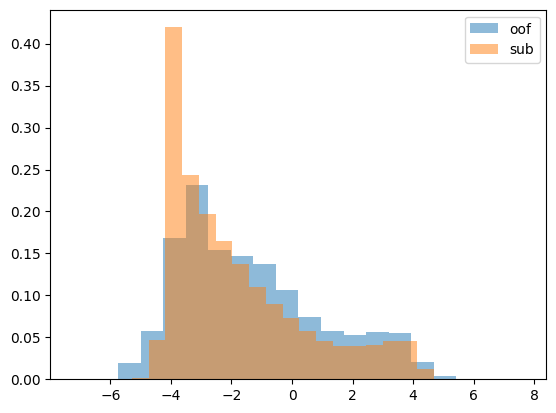

In [39]:
plt.hist(oof['pred_0'], density=True, alpha=0.5, label='oof', bins=20)
plt.hist(sub_oof['pred_0'], density=True, alpha=0.5, label='sub', bins=20)

plt.legend()
plt.show()

In [40]:
# sub_oof['session_id'] = test_df['session_id']
# sub_oof['yad_no'] = test_df['yad_no']

## 2stage用に残すもの  

最初にロードしたときのdfにあるcolumns 

past_itemのrank  
fold  
candidate_name  
pred (全部保存して、Rerankのときにsort→topkする)

In [41]:
remain_cols = ['session_id', 'yad_no',	'rank_past_item',	'candidate_name_num',
               'fold', 'pred_0', 'is_duplicated'] + list(set(['target', CFG.target_col]))
output_dir = CFG.outputs_path + 'oof/'
os.makedirs(output_dir, exist_ok=True)
oof = oof[remain_cols]
oof.to_pickle(output_dir + 'oof.pkl')

remain_cols = ['session_id', 'yad_no',	'rank_past_item',	'candidate_name_num',
               'pred_0']

sub_oof = sub_oof[remain_cols]
sub_oof[remain_cols].to_pickle(output_dir + 'sub_oof.pkl')

## sort

In [42]:
# use_cols = [col for col in oof.columns if col not in num_cols]
# oof = oof[use_cols]

In [43]:
# use_cols = [col for col in sub_oof.columns if col not in num_cols]
# sub_oof = sub_oof[use_cols]

In [44]:
oof = oof.sort_values(['session_id', 'pred_0'], ascending=[True, False]).reset_index(drop=True)
sub_oof = sub_oof.sort_values(['session_id', 'pred_0'], ascending=[True, False]).reset_index(drop=True)

# oof = oof.sort_values(['session_id', 'candidate_name_rank', 'pred_0'], ascending=[True, True, False]).reset_index(drop=True)
# sub_oof = sub_oof.sort_values(['session_id', 'candidate_name_rank', 'pred_0'], ascending=[True, True, False]).reset_index(drop=True)

In [45]:
def session_to_pred_list(session_df: pd.DataFrame, session_only_df: pd.DataFrame):
    pred_df = session_df.groupby('session_id')['yad_no'].apply(lambda x: x.tolist()).reset_index()
    pred_df = pd.merge(session_only_df, pred_df, on='session_id', how='left')

    pred_df['yad_no'] = pred_df['yad_no'].apply(lambda d: d if isinstance(d, list) else [])

    return pred_df['yad_no'].to_list()

In [46]:
train_pred_list = session_to_pred_list(oof, train_session_only_df)
test_pred_list = session_to_pred_list(sub_oof, test_session_only_df)

In [47]:
train_pred_list = [list(dict.fromkeys(pred)) for pred in train_pred_list]
test_pred_list = [list(dict.fromkeys(pred)) for pred in test_pred_list]

In [48]:
map_10 = mapk(train_label_df['yad_no'].to_list(), train_pred_list, k=10)
Logger.info(f'map10: {map_10}')

map10: 0.40997202327208077


In [49]:
def make_submission(test_pred_list):
    results = []
    cnts = []
    for pred in test_pred_list:
        
        pred = pred[:10]
        # print(pred)
        # pred = [int(p) for p in pred]
        
        cnt = len(pred)
        cnts.append(cnt)
        if cnt != 10:
            pred.extend([0] * (10 - cnt))
        results.append(pred)
    
    columns = [f'predict_{i}' for i in range(10)]
    submission = pd.DataFrame(results, columns=columns)

    plt.hist(cnts)
    return submission

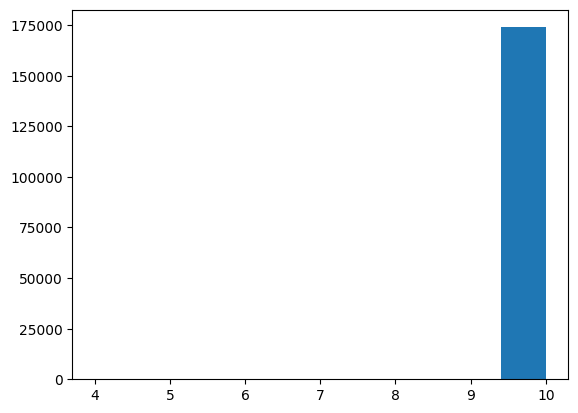

In [50]:
sub = make_submission(test_pred_list)

In [51]:
sub

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,9534,11561,5466,6488,4714,2680,6563,4420,5785
1,8108,6129,143,613,4066,7014,11923,10095,11237,9323
2,757,7710,9190,9910,1774,13570,410,10485,6721,6730
3,12341,6991,3359,13521,1542,10861,10746,4180,9319,5657
4,2862,9020,763,10826,11480,607,13235,5650,3476,12524
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,12942,11123,7062,9743,6813,10997,7780
174696,4014,3802,1227,899,12432,3644,2232,13220,9723,6874
174697,13241,11037,844,13719,8143,13797,8123,7379,5944,12132
174698,3100,13672,3002,2373,5515,1687,6034,4483,5513,2407


In [52]:
sub.to_csv(
    CFG.submission_dir + f'submission_{CFG.exp_name}.csv', index=False)

In [53]:
# sessionが変わるところで1行空けて、ログを見やすいようにする
def save_log_df(log_df):
    results = []
    prev_session_id = log_df.iloc[0]['session_id']
    for _, row in log_df.iterrows():
        session_id = row['session_id']
        if prev_session_id != session_id:
            results.append([np.nan]*len(log_df.columns))
        results.append(row.tolist())
        prev_session_id = session_id
    
    results = pd.DataFrame(results, columns=log_df.columns)

    return results

In [54]:
save_log_df(oof.head(10000)).to_csv(CFG.outputs_path + 'oof_1000.csv', index=False)

In [55]:
oof.sort_values(['yad_no', 'session_id', 'pred_0'], ascending=[True, True, False]).head(10000).to_csv(CFG.outputs_path + 'oof_1000_type2.csv', index=False)

## train test 重複

In [56]:
train_session_to_log_yad_dict = train_log_df.groupby('session_id')['yad_no'].apply(tuple).to_dict()
test_session_to_log_yad_dict = test_log_df.groupby('session_id')['yad_no'].apply(tuple).to_dict()

In [57]:
train_log_yad_tuple_set = set(list(train_session_to_log_yad_dict.values()))
test_log_yad_tuple_set = set(list(test_session_to_log_yad_dict.values()))

In [58]:
len(train_log_yad_tuple_set), len(test_log_yad_tuple_set)

(100379, 64516)

In [59]:
# test内の約2/3が重複
len((train_log_yad_tuple_set & test_log_yad_tuple_set))

43920

In [60]:
duplicated_session_list = []
for session_id, log_yad_tuple in test_session_to_log_yad_dict.items():
    if log_yad_tuple in train_log_yad_tuple_set:
        duplicated_session_list.append(session_id)
duplicated_session_df = pd.DataFrame(duplicated_session_list, columns=['session_id'])
duplicated_session_df['is_log_duplicated'] = 1

In [61]:
sub_oof = pd.merge(sub_oof, duplicated_session_df, on='session_id', how='left')
sub_oof['is_log_duplicated'] = sub_oof['is_log_duplicated'].fillna(0)

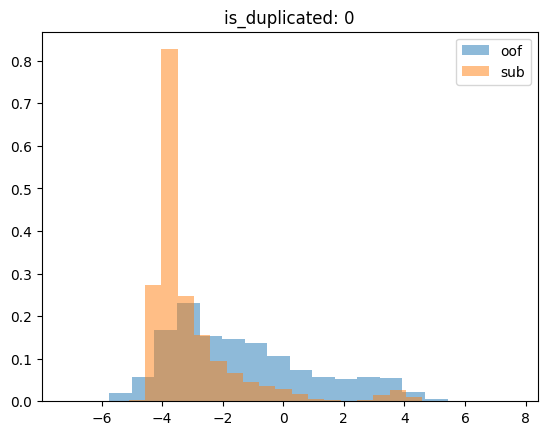

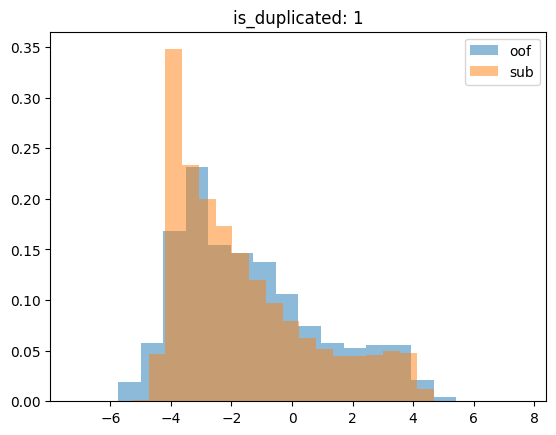

In [62]:
for is_duplicated in [0, 1]:

  plt.hist(oof['pred_0'], density=True, alpha=0.5, label='oof', bins=20)
  plt.hist(sub_oof[sub_oof['is_log_duplicated']==is_duplicated]['pred_0'], density=True, alpha=0.5, label='sub', bins=20)

  plt.legend()
  plt.title(f'is_duplicated: {is_duplicated}')
  plt.show()